In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import logging
import xarray as xr
import numpy as np
from pathlib import Path
from rasterio.warp import Resampling
from matplotlib import pyplot as plt

from disp_xr.log.logging import setup_logging
from disp_xr import product, quality_metrics, utils, stack as st
from disp_xr.io import write_geotiff, get_geospatial_info, open_image, reproject_raster

logger = logging.getLogger('disp_xr')
setup_logging(logger_name='disp_xr')

In [2]:
# Get DISP version 0.9 data
disp_df = product.get_disp_info('/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622')

# Directories
work_dir = '/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy'

static_dir = Path(work_dir) / 'static_lyr'
static_dir.mkdir(exist_ok=True)

temp_dir = Path(work_dir) / 'temp_geometry'
temp_dir.mkdir(exist_ok=True)

[INFO|product|L23] 2025-02-22T14:06:29-0800: Found OPERA DISP: 687 products
[INFO|product|L42] 2025-02-22T14:06:29-0800:  Starting date: 2016-07-16 22:50:42
[INFO|product|L43] 2025-02-22T14:06:29-0800:  Ending date: 2024-12-13 22:51:21
[INFO|product|L47] 2025-02-22T14:06:29-0800:  Versions: ['v1.0' 'v0.8' 'v1.1']
[INFO|product|L51] 2025-02-22T14:06:29-0800:  filtered with v1.1: 239 products
[INFO|product|L54] 2025-02-22T14:06:29-0800:  Number of reference dates: 16
[INFO|product|L91] 2025-02-22T14:06:29-0800:  Skip 0 duplicates


In [68]:
import asf_search as asf
import warnings
import shutil
from opera_utils.geometry import stitch_geometry_layers
def get_static_layers(disp_path: str | Path, 
                      output_dir: str | Path, 
                      n_workers: int = 5) -> dict:
    """
    Get static layers for DISP data.
    """

    # Create output directory if does not exist 
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    # Create temporary directory for downloading static layers
    temp_dir = output_dir / 'tmp'
    temp_dir.mkdir(exist_ok=True)
    
    # Get burst ids
    burst_ids = utils.get_burst_ids(disp_path)

    # Download static layers
    results = asf.search(
        operaBurstID=list(burst_ids),
        processingLevel='CSLC-STATIC',
    )
    
    logger.info(f'Static layer files to download: {len(results)}')
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
        results.download(path=temp_dir, processes=n_workers)

    # Get static layer paths
    list_static_files = [Path(f'{static_dir}/{results[ii].properties["fileName"]}')
                    for ii in range(len(results)) ] 
    
    # Stitch static layers: generate los_east.tif, los_north.tif, layover_shadow.tif
    logger.info(f'Stitching burst static layers to {output_dir}')
    _ = stitch_geometry_layers(list_static_files,
                                output_dir=output_dir)

    # Generate los_up.tif
    los_east, los_east_atr = open_image(output_dir / 'los_east.tif')
    los_north, _ = open_image(output_dir / 'los_north.tif')

    # Ensure los_east and los_north are on the same grid as DISP
    geo_info = get_geospatial_info(disp_path)
    atr = dict(rows=geo_info.rows, cols=geo_info.cols)
    
    for txt, data in zip(['los_east.tif', 'los_north.tif'],
                         [los_east, los_north]):
        logger.info(f'Reprojecting {(output_dir / txt).name} to DISP grid')
        reproject_raster(output_name = output_dir / txt,
                        src_data = data,
                        atr = atr,
                        src_transform = los_east_atr['gt'],
                        dst_transform = geo_info.transform,
                        src_crs = los_east_atr['crs'],
                        dst_crs = geo_info.crs,
                        dtype='float32',
                        resampling_mode = Resampling.bilinear)

    logger.info(f'Writing los_up {output_dir}')
    # Read los_east and los_north
    los_east, los_east_atr = open_image(output_dir / 'los_east.tif')
    los_north, _ = open_image(output_dir / 'los_north.tif')

    # Get los_up
    mask = np.ma.masked_equal(los_east, 0).mask
    up = np.sqrt(1 - los_east**2 - los_north**2)
    up = np.ma.masked_array(up, mask=mask).filled(0)

    # Write los_up to file
    write_geotiff(
        output_dir / 'los_up.tif',
        up,
        los_east_atr['bounds'],
        epsg=los_east_atr['crs'].to_epsg(),
    )

    # Delete temporary directory
    shutil.rmtree(temp_dir)

    return {'los_east': output_dir / 'los_east.tif',
            'los_north': output_dir / 'los_north.tif',
            'los_up': output_dir / 'los_up.tif',
            'layover_shadow': output_dir / 'layover_shadow.tif'}

In [48]:
def los_unit2inc_azimuth(los_east: str | Path, los_north: str | Path,
                         output_dir: str | Path) -> dict:
    
    # Read los_east and los_north
    try:
        los_ew, los_east_atr = open_image(los_east)
    except FileNotFoundError:
        raise ValueError(f'File {los_east} not found')
    
    try:
        los_ns, _ = open_image(los_north)
    except FileNotFoundError:
        raise ValueError(f'File {los_north} not found')

    # Create output directory if does not exist 
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    # Get los_up
    up = np.sqrt(1 - los_ew**2 - los_ns**2)
    # Get azimuth and incidence angles
    az_angle = -1 * np.rad2deg(np.arctan2(los_ew, los_ns)) % 360
    incidence_angle = np.rad2deg(np.arccos(up))

    # Write azimuth and incidence angles to file
    logger.info(f'Writing azimuth and incidence angles to {output_dir}')
    write_geotiff(
        output_dir / 'azimuth.tif',
        az_angle,
        los_east_atr['bounds'],
        epsg=los_east_atr['crs'].to_epsg(),
    )
    write_geotiff(
        output_dir / 'incidence.tif',
        incidence_angle,
        los_east_atr['bounds'],
        epsg=los_east_atr['crs'].to_epsg(),
    )
    return {'inc_angle': output_dir / 'incidence.tif',
            'az_angle': output_dir / 'azimuth.tif'}

In [69]:
static_paths = get_static_layers(disp_df.path.iloc[0], 
                            '/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry',
                            n_workers=5)

[INFO|456526388|L29] 2025-02-22T15:00:59-0800: Static layer files to download: 25
[INFO|456526388|L39] 2025-02-22T15:01:21-0800: Stitching burst static layers to /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry
[INFO|456526388|L53] 2025-02-22T15:01:22-0800: Reprojecting los_east.tif to DISP grid
[INFO|456526388|L53] 2025-02-22T15:01:24-0800: Reprojecting los_north.tif to DISP grid
[INFO|456526388|L64] 2025-02-22T15:01:26-0800: Writing los_up /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry


In [71]:
static_paths

{'los_east': PosixPath('/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry/los_east.tif'),
 'los_north': PosixPath('/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry/los_north.tif'),
 'los_up': PosixPath('/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry/los_up.tif'),
 'layover_shadow': PosixPath('/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry/layover_shadow.tif')}

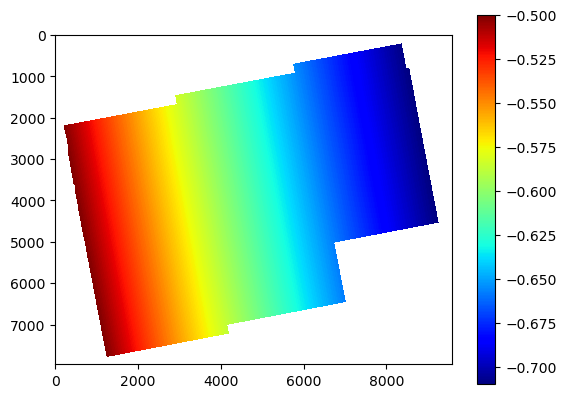

In [70]:
inc, _ = open_image(static_paths['los_east'])
plt.imshow(np.ma.masked_equal(inc,0), cmap='jet', interpolation='nearest')
plt.colorbar()

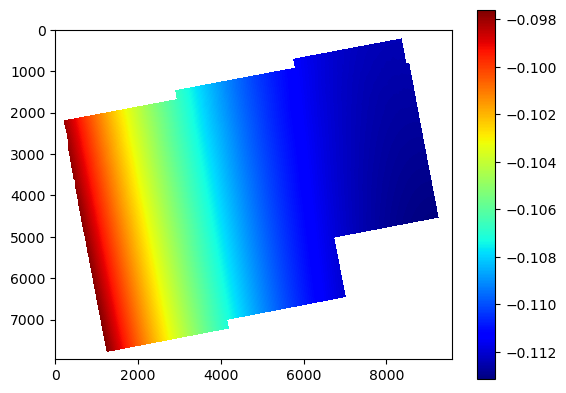

In [72]:
inc, _ = open_image(static_paths['los_north'])
plt.imshow(np.ma.masked_equal(inc,0), cmap='jet', interpolation='nearest')
plt.colorbar()

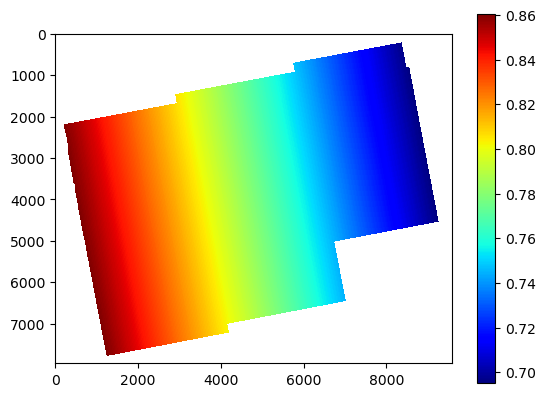

In [73]:
inc, _ = open_image(static_paths['los_up'])
plt.imshow(np.ma.masked_equal(inc,0), cmap='jet', interpolation='nearest')
plt.colorbar()

In [74]:
inc_az_paths = los_unit2inc_azimuth(static_paths['los_east'], static_paths['los_north'],
                                   '/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry')

[INFO|2671217551|L26] 2025-02-22T15:02:32-0800: Writing azimuth and incidence angles to /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry


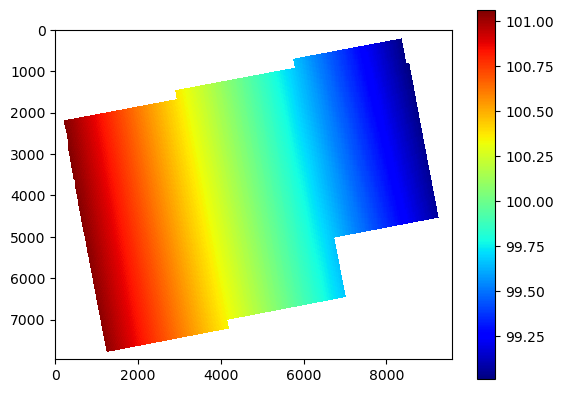

In [75]:
inc, _ = open_image(inc_az_paths['az_angle'])
plt.imshow(np.ma.masked_equal(inc,0), cmap='jet', interpolation='nearest')
plt.colorbar()

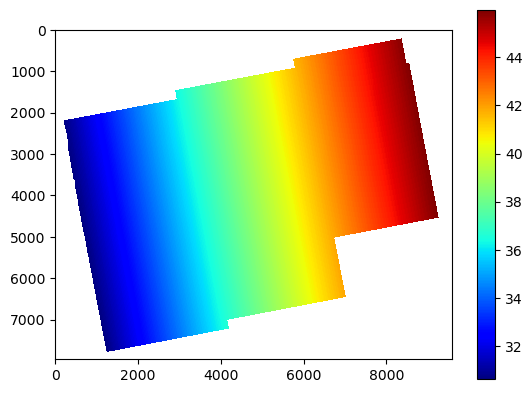

In [76]:
inc, _ = open_image(inc_az_paths['inc_angle'])
plt.imshow(np.ma.masked_equal(inc,0), cmap='jet', interpolation='nearest')
plt.colorbar()

## DEM and Water Mask

In [77]:
from pyproj import Transformer
import dem_stitcher, tile_mate
def download_dem(disp_path : str | Path, output_dir: str| Path) -> str:
    # Create output directory if does not exist 
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    # Get geospatial info
    geo_info = get_geospatial_info(disp_path)

    # Init projection converter
    transformer = Transformer.from_crs(f'EPSG:{geo_info.crs.to_epsg()}',
                                        "EPSG:4326",
                                        always_xy=True)
    
    # Get bounds in geographic coordinates
    snwe = np.zeros((4))
    snwe[2], snwe[1] = transformer.transform(geo_info.bounds.left-1e3,
                                             geo_info.bounds.top+1e3)
    snwe[3], snwe[0] = transformer.transform(geo_info.bounds.right+1e3,
                                             geo_info.bounds.bottom-1e3)
    bounds = [snwe[2], snwe[0], snwe[3], snwe[1]]

    # Download dem
    logger.info(f'Downloading DEM for bounds: {np.queeze(bounds)}')
    atr = dict(rows=geo_info.rows, cols=geo_info.cols)
    dem_data, dem_attr = dem_stitcher.stitch_dem(bounds,
                                                 dem_name='glo_30',
                                                 dst_ellipsoidal_height=True,
                                                 dst_area_or_point='Point')
    


    logger.info(f'Saving DEM: {output_dir / 'dem.tif'}')
    reproject_raster(output_name = output_dir / 'dem.tif',
                    src_data = dem_data,
                    atr = atr,
                    src_transform = dem_attr['transform'],
                    dst_transform = geo_info.transform, 
                    src_crs = dem_attr['crs'],
                    dst_crs =  geo_info.crs,
                    dtype = 'float32',
                    resampling_mode = Resampling.bilinear) 
    return output_dir / 'dem.tif'


def download_water_mask(disp_path : str | Path, output_dir: str| Path) -> str:
    # Create output directory if does not exist 
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    # Get geospatial info
    geo_info = get_geospatial_info(disp_path)

    # Init projection converter
    transformer = Transformer.from_crs(f'EPSG:{geo_info.crs.to_epsg()}',
                                        "EPSG:4326",
                                        always_xy=True)
    
    # Get bounds in geographic coordinates
    snwe = np.zeros((4))
    snwe[2], snwe[1] = transformer.transform(geo_info.bounds.left-1e3,
                                             geo_info.bounds.top+1e3)
    snwe[3], snwe[0] = transformer.transform(geo_info.bounds.right+1e3,
                                             geo_info.bounds.bottom-1e3)
    bounds = [snwe[2], snwe[0], snwe[3], snwe[1]]

    # Download water mask
    logger.info(f'Downloading water mask for bounds: {np.queeze(bounds)}')
    atr = dict(rows=geo_info.rows, cols=geo_info.cols)
    mask_data, mask_attr = tile_mate.get_raster_from_tiles(bounds,
                                       tile_shortname='esa_world_cover_2021')
    
    # Make byte mask
    mask_data[mask_data == 80] = 0
    mask_data[mask_data != 0] = 1
    mask_data = mask_data.astype('byte')

    logger.info(f'Saving Water Mask: {output_dir / 'water_mask.tif'}')
    reproject_raster(output_name = output_dir / 'water_mask.tif',
                    src_data = mask_data,
                    atr = atr,
                    src_transform = mask_attr['transform'],
                    dst_transform = geo_info.transform, 
                    src_crs = mask_attr['crs'],
                    dst_crs =  geo_info.crs,
                    dtype = 'uint8',
                    resampling_mode = Resampling.nearest) 
    return output_dir / 'water_mask.tif'

In [78]:
dem_path = download_dem(disp_df.path.iloc[0],
                        '/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry')
water_mask_path = download_water_mask(disp_df.path.iloc[0],
                         '/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry')

[INFO|504361537|L25] 2025-02-22T15:12:51-0800: Downloading DEM for bounds: [np.float64(-75.44555749789923), np.float64(39.690614286162145), np.float64(-72.05366929059791), np.float64(41.89613243561921)]
Reading tile imagery: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]
[INFO|504361537|L34] 2025-02-22T15:13:39-0800: Saving DEM: /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry/dem.tif
[INFO|504361537|L69] 2025-02-22T15:13:44-0800: Downloading water mask for bounds: [np.float64(-75.44555749789923), np.float64(39.690614286162145), np.float64(-72.05366929059791), np.float64(41.89613243561921)]
Reading tile imagery: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]
[INFO|504361537|L79] 2025-02-22T15:14:22-0800: Saving Water Mask: /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry/water_mask.tif


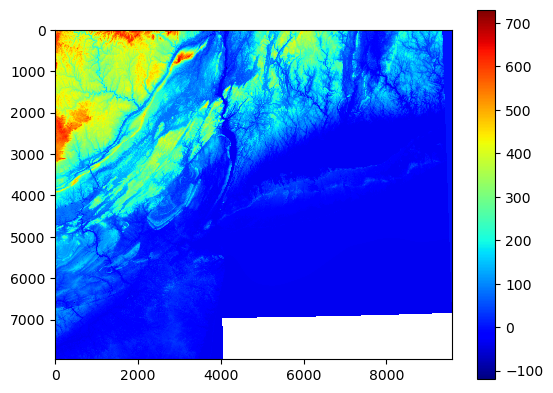

In [79]:
dem = open_image(dem_path)[0]
plt.imshow(dem, cmap='jet', interpolation='nearest')
plt.colorbar()

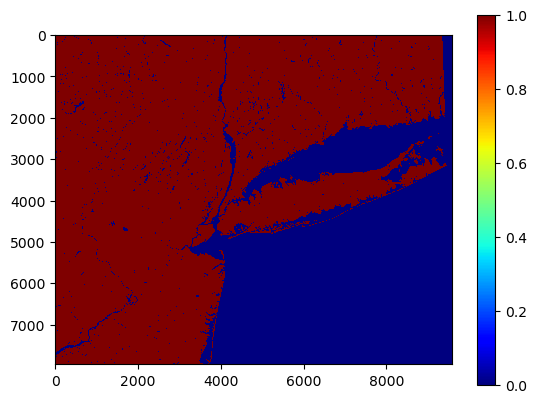

In [80]:
water = open_image(water_mask_path)[0]
plt.imshow(water, cmap='jet', interpolation='nearest')
plt.colorbar()

# MINTPY

In [83]:
import datetime
import h5py
from pyproj import CRS
import pandas as pd
def get_metadata(disp_nc : str | Path, reference_date :str = None) -> dict:
    """
    Get metadata for MINTPY from a DISP NetCDF file.

    Args:
        disp_nc (str or Path): The path to the DISP NetCDF file.
        reference_date (str, optional): The reference date. Defaults to None.

    Returns:
        dict: A dictionary containing the metadata.

    """

    # Get high-level metadata from DISP
    ds = h5py.File(disp_nc, 'r')
    length, width = ds['displacement'][:].shape 

    # Get general metadata
    metadata = {}
    for key, value in ds.attrs.items():
        metadata[key] = value

    for key, value in ds['identification'].items():
        value = value[()]
        if isinstance(value, (bytes, bytearray)):
            value = value.decode('utf-8')
        metadata[key] = value

    for key, value in ds['metadata'].items():
        # Skip unnecessary keys
        if key not in ['reference_orbit',
                       'secondary_orbit',
                       'processing_information']:
            metadata[key] = value[()]
    
    metadata['x'] = ds['x'][:]
    metadata['y'] = ds['y'][:]
    metadata['length'] = length
    metadata['width'] = width
    ds.close()
    del ds

    # Get geospatial information
    geo_info = get_geospatial_info(disp_nc)

    ## Prepare it in mintpy atr format
    metadata["LENGTH"] = geo_info.rows
    metadata["WIDTH"] = geo_info.cols

    metadata["X_FIRST"] = geo_info.gt[0]
    metadata["Y_FIRST"] = geo_info.gt[3]
    metadata["X_STEP"] = geo_info.gt[1]
    metadata["Y_STEP"] = geo_info.gt[5]
    metadata['GT'] = geo_info.transform
    metadata["X_UNIT"] = metadata["Y_UNIT"] = "meters"
    metadata['WAVELENGTH'] = metadata['radar_wavelength']
    metadata['REF_DATE'] = reference_date

    # Projection and UTM zone
    proj = CRS.from_wkt(geo_info.crs.wkt)
    metadata['UTM_ZONE'] = proj.name.split(' ')[-1]
    metadata['EPSG'] = proj.to_authority()[-1]

    # Hardcoded values
    metadata['ALOOKS'] = metadata['RLOOkS'] = 1
    metadata['EARTH_RADIUS'] = 6371000.0  # Hardcoded
    metadata["FILE_TYPE"] = "timeseries"
    metadata["UNIT"] = "m"
    metadata["AZIMUTH_PIXEL_SIZE"] = 14.1 # where this comes from

    # Datetime
    t = pd.to_datetime([metadata['reference_zero_doppler_start_time'],
                        metadata['reference_zero_doppler_end_time']])
    t_mid = t[0] + t.diff()[1] /2
    total_seconds = t_mid.hour*3600 + t_mid.minute*60 + t_mid.second + t_mid.microsecond/1e6
    metadata["CENTER_LINE_UTC"] = total_seconds

    # Clean up of metadata dicts
    for key in ['reference_datetime', 'secondary_datetime']:
        del metadata[key]

    return metadata

In [81]:
from mintpy.utils import writefile

def write_mintpy_geometry(disp_paths : str | Path,
                          incidence_angle : str | Path,
                          azimuth_angle : str | Path,
                          dem_path : str | Path,
                          water_mask_path : str | Path,
                          output_dir : str | Path):
    
    # Create output directory if does not exist
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    # Open incidence and azimuth angles
    files = {}
    for txt, path in zip(['inc_angle', 'az_angle', 'dem', 'water_mask'],
                     [incidence_angle, azimuth_angle, dem_path, water_mask_path]):
        logger.info(f'Reading {path}')
        try:
            files[txt], _ = open_image(path)
        except FileNotFoundError:
            raise ValueError(f'File {path} not found')
        
    # Get metadata
    # NOTE suspend temporary logging here
    disp_df = product.get_disp_info(disp_paths)
    reference_date = disp_df.date1.min()
    metadata = get_metadata(disp_df.path.iloc[0], reference_date=reference_date)

    # Save mintpy geometry
    logger.info(f'Writing geometry.h5 to {output_dir}')
    meta = {key: value for key, value in metadata.items()}
    meta["FILE_TYPE"] = "geometry"

    dsDict = {
        "incidenceAngle": files['inc_angle'],
        "azimuthAngle": files['az_angle'],
        "height": files['dem'],
        "waterMask" : files['water_mask'],
    }

    writefile.write(dsDict, Path(work_dir) / 'geometry.h5', metadata=meta)  

In [84]:
geom = Path('/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry')
write_mintpy_geometry('/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622',
                      geom / 'incidence.tif',
                      geom / 'azimuth.tif',
                      geom / 'dem.tif',
                      geom / 'water_mask.tif',
                      '/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry')

[INFO|1520975622|L18] 2025-02-22T15:28:04-0800: Reading /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry/incidence.tif
[INFO|1520975622|L18] 2025-02-22T15:28:04-0800: Reading /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry/azimuth.tif
[INFO|1520975622|L18] 2025-02-22T15:28:05-0800: Reading /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry/dem.tif
[INFO|1520975622|L18] 2025-02-22T15:28:05-0800: Reading /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry/water_mask.tif
[INFO|product|L23] 2025-02-22T15:28:05-0800: Found OPERA DISP: 687 products
[INFO|product|L42] 2025-02-22T15:28:05-0800:  Starting date: 2016-07-16 22:50:42
[INFO|product|L43] 2025-02-22T15:28:05-0800:  Ending date: 2024-12-13 22:51:21
[INFO|product|L47] 2025-02-22T15:28:05-0800:  Versions: ['v1.0' 'v0.8' 'v1.1']
[INFO|product|L51] 2025-02-22T15:28:05-0800:  filtered with v1.1: 239 products
[INFO|product|L54] 2025-02-22T15:28:05-0800:  Number of reference dates: 16
[INFO|product|L91] 2025-02-22T15:28:05-08

delete exsited file: /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry.h5
create HDF5 file: /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry.h5 with w mode
create dataset /incidenceAngle of float32    in size of (7959, 9587)         with compression=None
create dataset /azimuthAngle   of float32    in size of (7959, 9587)         with compression=None
create dataset /height         of float32    in size of (7959, 9587)         with compression=None
create dataset /waterMask      of uint8      in size of (7959, 9587)         with compression=None
finished writing to /u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry.h5


In [148]:
# Get DISP version 0.9 data
disp_df = product.get_disp_info('/u/duvel-d2/govorcin/NJ/ASC/v1.1/28220')

# Directories
work_dir = '/u/duvel-d2/govorcin/NJ/ASC/v1.1/28220/mintpy'

static_dir = Path(work_dir) / 'static_lyr'
static_dir.mkdir(exist_ok=True)

temp_dir = Path(work_dir) / 'temp_geometry'
temp_dir.mkdir(exist_ok=True)

[INFO|product|L23] 2025-02-22T13:52:15-0800: Found OPERA DISP: 239 products
[INFO|product|L42] 2025-02-22T13:52:15-0800:  Starting date: 2016-07-09 22:58:15
[INFO|product|L43] 2025-02-22T13:52:15-0800:  Ending date: 2024-09-13 22:58:56
[INFO|product|L54] 2025-02-22T13:52:15-0800:  Number of reference dates: 16
[INFO|product|L91] 2025-02-22T13:52:15-0800:  Skip 0 duplicates


In [149]:
print('\nCreating MINTPY cube: ', Path(work_dir) / 'geometry.h5')
inc, atr = open_image(Path(temp_dir) / 'incidence_angle.tif')
azi, atr = open_image(Path(temp_dir) / 'azimuth_angle.tif')
mask = np.ma.masked_equal(inc, 0).mask
dem, atr = open_image(Path(temp_dir) / 'dem.tif')
dem = np.ma.masked_array(dem, mask=mask).filled(0)
water, atr = open_image(Path(temp_dir) / 'water_mask.tif')
water = np.ma.masked_array(water, mask=mask).filled(0)


Creating MINTPY cube:  /u/duvel-d2/govorcin/NJ/ASC/v1.1/28220/mintpy/geometry.h5


In [150]:
# Get metadata
reference_date = disp_df.date1.min()
metadata = get_metadata(disp_df.path.iloc[0], reference_date=reference_date)

In [151]:
# Save mintpy geometry
meta = {key: value for key, value in metadata.items()}
meta["FILE_TYPE"] = "geometry"

dsDict = {
    "incidenceAngle": inc,
    "azimuthAngle": azi,
    "height": dem,
    "waterMask" : water,
}

writefile.write(dsDict, Path(work_dir) / 'geometry.h5', metadata=meta)  

delete exsited file: /u/duvel-d2/govorcin/NJ/ASC/v1.1/28220/mintpy/geometry.h5
create HDF5 file: /u/duvel-d2/govorcin/NJ/ASC/v1.1/28220/mintpy/geometry.h5 with w mode
create dataset /incidenceAngle of float32    in size of (7846, 9529)         with compression=None
create dataset /azimuthAngle   of float32    in size of (7846, 9529)         with compression=None
create dataset /height         of float32    in size of (7846, 9529)         with compression=None
create dataset /waterMask      of uint8      in size of (7846, 9529)         with compression=None
finished writing to /u/duvel-d2/govorcin/NJ/ASC/v1.1/28220/mintpy/geometry.h5


PosixPath('/u/duvel-d2/govorcin/NJ/ASC/v1.1/28220/mintpy/geometry.h5')

: 

: 

: 